**Dataset Loading**


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the dataset
file_path = '/content/St johns.csv'
data = pd.read_csv(file_path)

# Convert 'Date and Time' to datetime and set as index
data['Date and Time'] = pd.to_datetime(data['Date and Time'])
data.set_index('Date and Time', inplace=True)

<ipython-input-137-f76e6175ba30>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date and Time'] = pd.to_datetime(data['Date and Time'])


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4224 entries, 2024-01-01 00:00:00 to 2024-06-20 11:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NO2     3795 non-null   float64
 1   PM10    3830 non-null   float64
 2   PM2.5   3830 non-null   float64
dtypes: float64(3)
memory usage: 132.0 KB


In [ ]:
# @title For Training Dataset do not run this code
# Drop rows with missing PM10 values
data = data.dropna(subset=['PM10'])

# Resample to daily average
data = data.resample('D').mean()

data = data.dropna()

# Function to create the required features
def create_features(df):
    df['PM10_RollingMean_3'] = df['PM10'].rolling(window=3).mean()
    df['PM10_RollingMean_1'] = df['PM10'].rolling(window=1).mean()
    df['PM10_Pct_Change'] = df['PM10'].pct_change()
    df['PM2.5_Pct_Change'] = df['PM2.5'].pct_change()
    df['PM10_NO2_Product'] = df['PM10'] * df['NO2']
    df = df.dropna()  # Drop rows with NaN values created by rolling mean and pct_change
    return df

#Apply the function to the dataset
data = create_features(data)

In [ ]:
data.isna().sum()

NO2                   0
PM10                  0
PM2.5                 0
PM10_RollingMean_3    0
PM10_RollingMean_1    0
PM10_Pct_Change       0
PM2.5_Pct_Change      0
PM10_NO2_Product      0
dtype: int64

**Modelling**

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA



ARIMAX



In [ ]:
# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

# Split the data into train and test
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [ ]:
# List of exogenous variables
exogenous_vars = [
    'NO2', 'PM2.5', 'PM10_RollingMean_3', 'PM10_RollingMean_1', 'PM10_Pct_Change', 'PM2.5_Pct_Change',
    'PM2.5_Pct_Change', 'PM10_NO2_Product'
]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmo

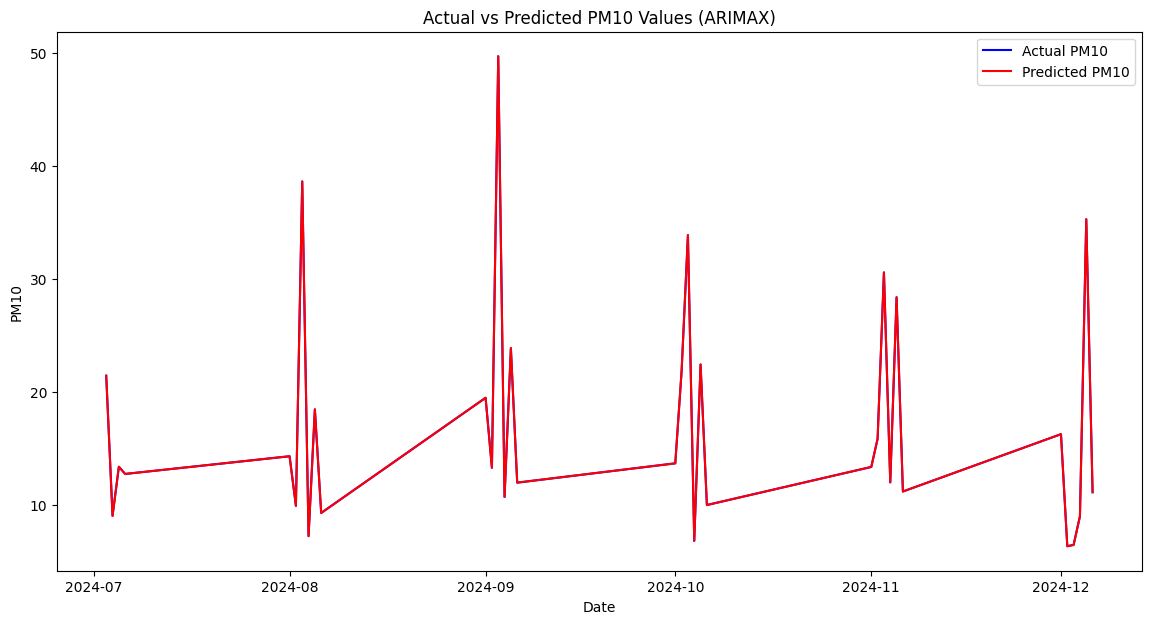

In [ ]:
# Train ARIMAX model
arimax_model = SARIMAX(
    train_data['PM10'],
    exog = train_data[exogenous_vars],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)
arimax_result = arimax_model.fit(disp=False)

# ARIMAX predictions
arimax_pred = arimax_result.get_forecast(steps=len(test_data), exog=test_data[exogenous_vars])
arimax_pred_mean = arimax_pred.predicted_mean

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['PM10'], label='Actual PM10', color='blue')
plt.plot(test_data.index, arimax_pred_mean, label='Predicted PM10', color='red')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10 Values (ARIMAX)')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE
arimax_rmse = np.sqrt(mean_squared_error(test_data['PM10'], arimax_pred_mean))
print(f"ARIMAX RMSE: {arimax_rmse}")
arimax_mae = mean_absolute_error(test_data['PM10'], arimax_pred_mean)
print(f"ARIMAX MAE: {arimax_mae}")

ARIMAX RMSE: 9.248503511698828e-09
ARIMAX MAE: 9.195363111470054e-09


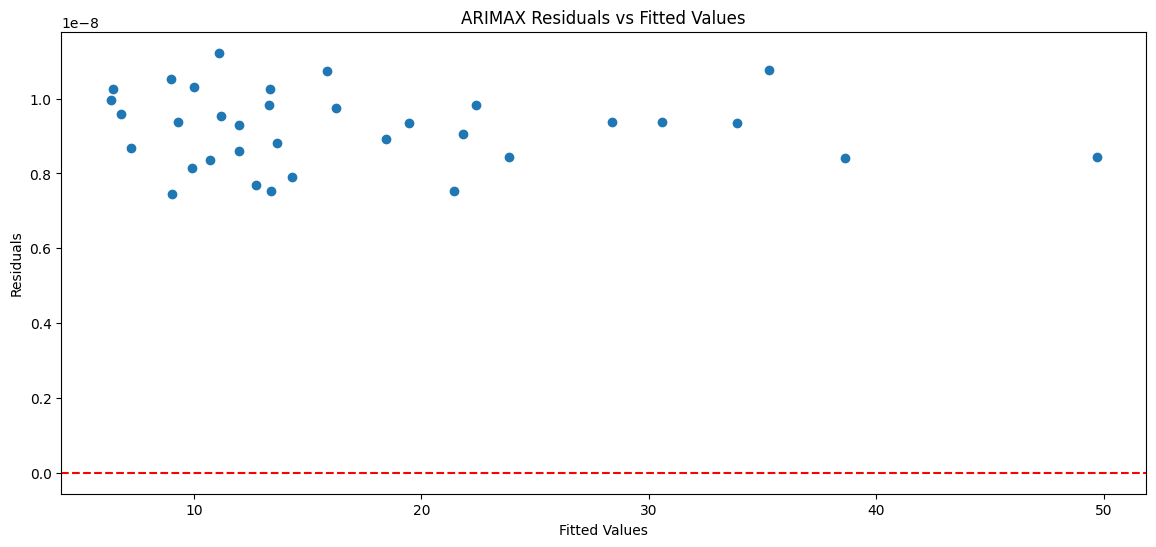

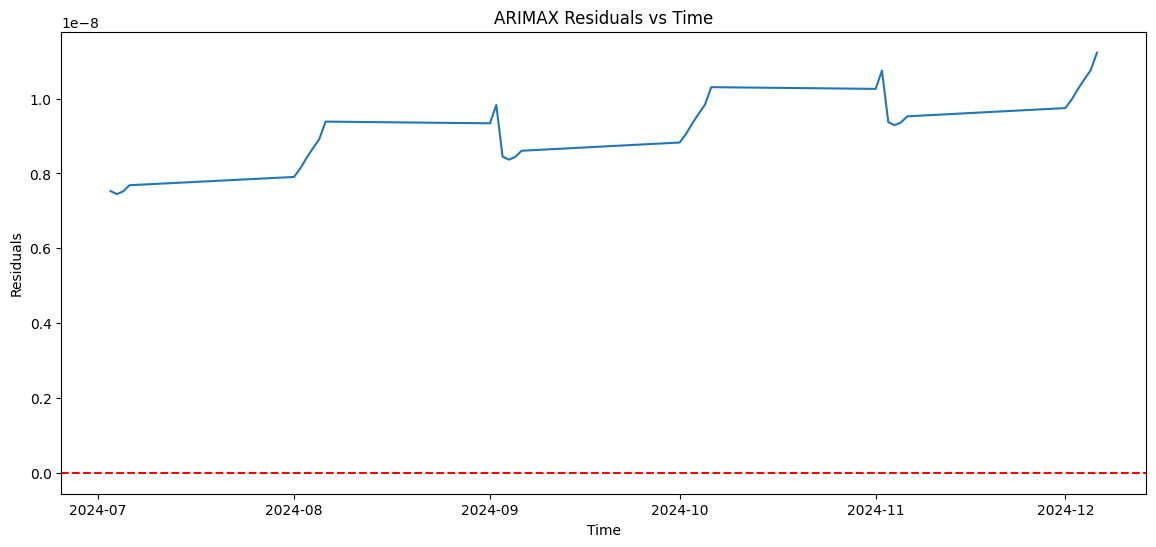

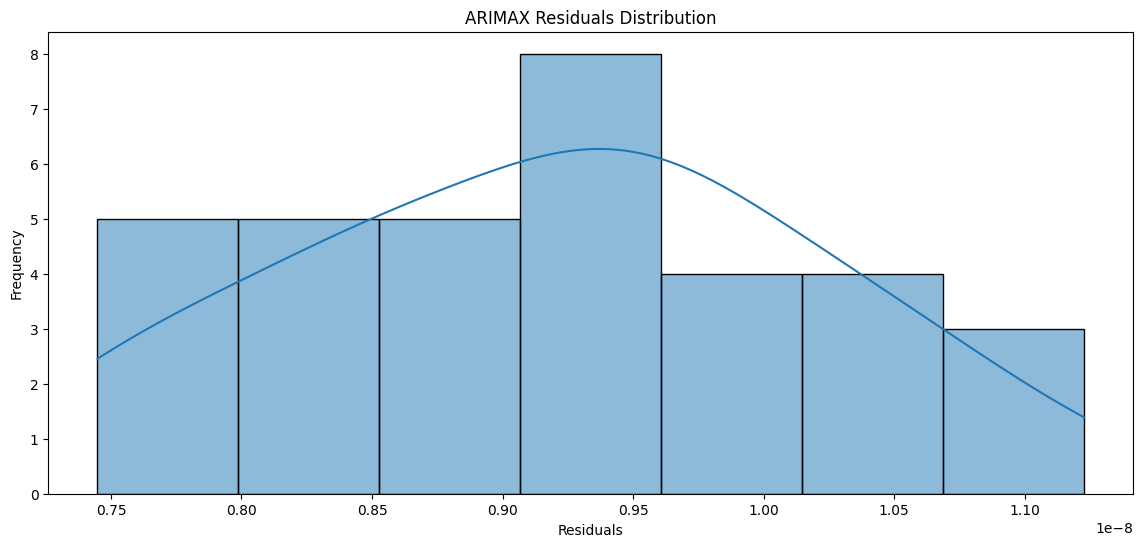

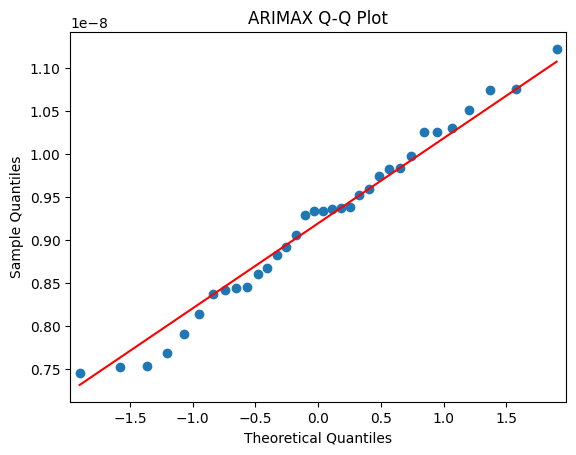

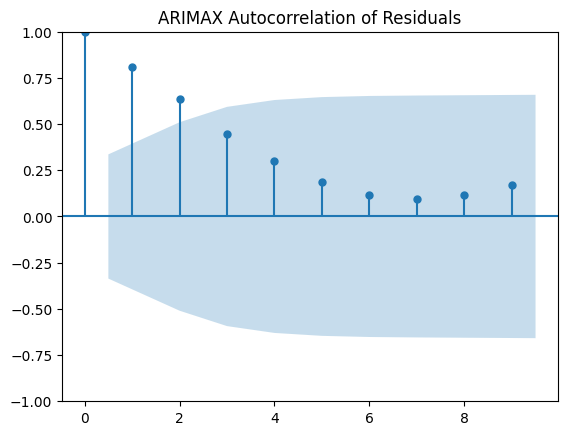

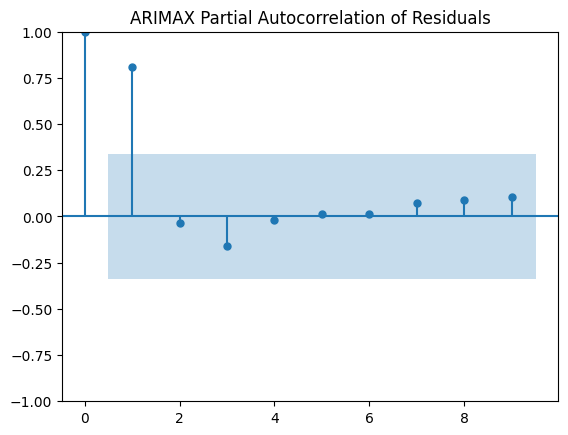

ARIMAX Residuals Analysis:
Shapiro-Wilk Test p-value: 0.6360224485397339
Breusch-Pagan Test p-value: 0.5739223250969574
Durbin-Watson Test statistic: 0.002056801141346036
Ljung-Box Test p-value: 4.627439009531727e-09


In [ ]:
# @title ARIMAX Residuals Analysis
# Ensure predictions and test data indices match
arimax_pred_mean = arimax_pred_mean[:len(test_data)]

# Calculate residuals
arimax_residuals = test_data['PM10'].values - arimax_pred_mean.values

# Residual vs. Fitted Values
plt.figure(figsize=(14, 6))
plt.scatter(arimax_pred_mean, arimax_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('ARIMAX Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Residuals vs. Time
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, arimax_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('ARIMAX Residuals vs Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(14, 6))
sns.histplot(arimax_residuals, kde=True)
plt.title('ARIMAX Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot
qqplot(arimax_residuals, line='s')
plt.title('ARIMAX Q-Q Plot')
plt.show()

# Autocorrelation Plot
num_lags = 9
plot_acf(arimax_residuals, lags=num_lags)
plt.title('ARIMAX Autocorrelation of Residuals')
plot_pacf(arimax_residuals, lags=num_lags)
plt.title('ARIMAX Partial Autocorrelation of Residuals')
plt.show()

# Statistical Tests
print('ARIMAX Residuals Analysis:')

# Shapiro-Wilk Test for normality
shapiro_test = shapiro(arimax_residuals)
print(f'Shapiro-Wilk Test p-value: {shapiro_test.pvalue}')

# Breusch-Pagan Test for heteroscedasticity
bp_test = het_breuschpagan(arimax_residuals, sm.add_constant(arimax_pred_mean))
print(f'Breusch-Pagan Test p-value: {bp_test[1]}')

# Durbin-Watson Test for autocorrelation
dw_test = durbin_watson(arimax_residuals)
print(f'Durbin-Watson Test statistic: {dw_test}')

# Ljung-Box Test for autocorrelation
ljung_box_test = acorr_ljungbox(arimax_residuals, lags=[10], return_df=True)
print(f'Ljung-Box Test p-value: {ljung_box_test["lb_pvalue"].values[0]}')



ANN 1



In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
data[exogenous_vars + ['PM10']] = scaler.fit_transform(data[exogenous_vars + ['PM10']])

In [ ]:
# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Prepare features and target variable
X_train = train_data[exogenous_vars]
y_train = train_data['PM10']
X_test = test_data[exogenous_vars]
y_test = test_data['PM10']

In [ ]:
# Build the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/80
4/4 [==============================] - 2s 122ms/step - loss: 0.0502 - val_loss: 0.0334
Epoch 2/80
4/4 [==============================] - 0s 17ms/step - loss: 0.0243 - val_loss: 0.0145
Epoch 3/80
4/4 [==============================] - 0s 18ms/step - loss: 0.0096 - val_loss: 0.0060
Epoch 4/80
4/4 [==============================] - 0s 25ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 5/80
4/4 [==============================] - 0s 24ms/step - loss: 0.0048 - val_loss: 0.0061
Epoch 6/80
4/4 [==============================] - 0s 21ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 7/80
4/4 [==============================] - 0s 23ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 8/80
4/4 [==============================] - 0s 23ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/80
4/4 [==============================] - 0s 30ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 10/80
4/4 [==============================] - 0s 44ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 11/80
4/4 [===========

2/2 [==============================] - 0s 9ms/step


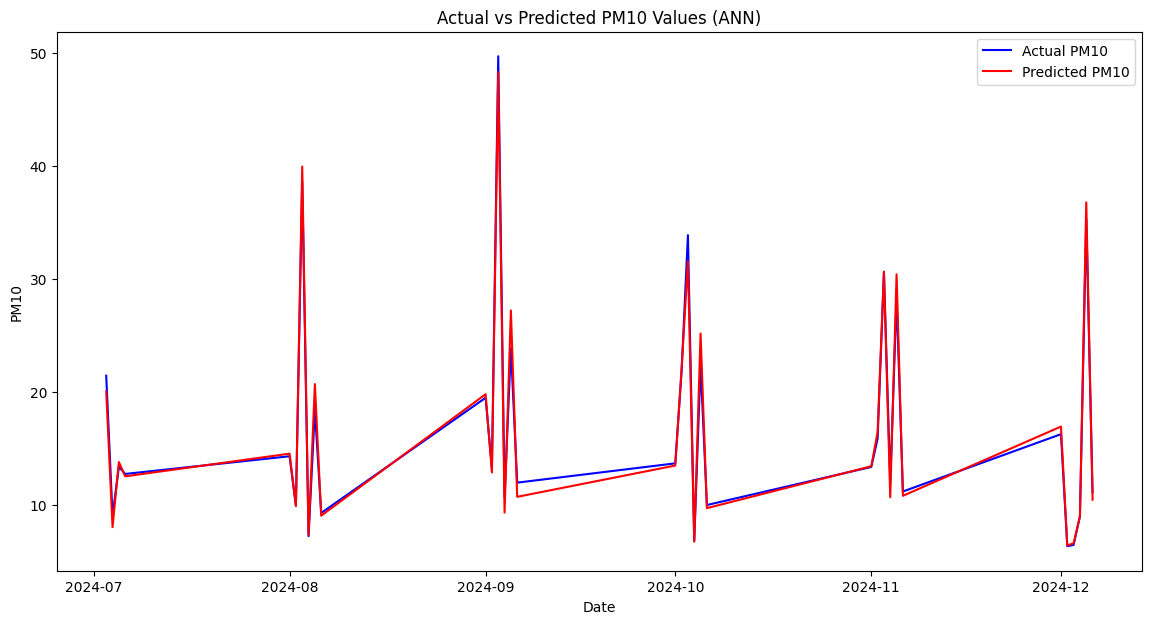

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
ann1_pred_inv = scaler.inverse_transform(np.concatenate([X_test, y_pred], axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate([X_test, y_test.values.reshape(-1, 1)], axis=1))[:, -1]

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test_inv, label='Actual PM10', color='blue')
plt.plot(test_data.index, ann1_pred_inv, label='Predicted PM10', color='red')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10 Values (ANN)')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE
ann1_rmse = np.sqrt(mean_squared_error(y_test_inv, ann1_pred_inv))
print(f"ANN 1 RMSE: {ann1_rmse}")
ann1_mae = mean_absolute_error(y_test_inv, ann1_pred_inv)
print(f"ANN 1 MAE: {ann1_mae}")

ANN 1 RMSE: 1.206312281556195
ANN 1 MAE: 0.8436929956848929




ANN 2



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [ ]:
# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Prepare features and target variable
X_train = train_data[exogenous_vars]
y_train = train_data['PM10']
X_test = test_data[exogenous_vars]
y_test = test_data['PM10']

In [ ]:
# Build the imporved ANN model with dropout
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Use early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping], verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
ann2_pred_inv = scaler.inverse_transform(np.concatenate([X_test, y_pred], axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate([X_test, y_test.values.reshape(-1, 1)], axis=1))[:, -1]

Epoch 1/80
4/4 [==============================] - 4s 109ms/step - loss: 0.0553 - val_loss: 0.0340
Epoch 2/80
4/4 [==============================] - 0s 17ms/step - loss: 0.0281 - val_loss: 0.0154
Epoch 3/80
4/4 [==============================] - 0s 17ms/step - loss: 0.0138 - val_loss: 0.0068
Epoch 4/80
4/4 [==============================] - 0s 17ms/step - loss: 0.0113 - val_loss: 0.0048
Epoch 5/80
4/4 [==============================] - 0s 21ms/step - loss: 0.0114 - val_loss: 0.0048
Epoch 6/80
4/4 [==============================] - 0s 20ms/step - loss: 0.0091 - val_loss: 0.0042
Epoch 7/80
4/4 [==============================] - 0s 19ms/step - loss: 0.0058 - val_loss: 0.0034
Epoch 8/80
4/4 [==============================] - 0s 24ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 9/80
4/4 [==============================] - 0s 18ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 10/80
4/4 [==============================] - 0s 22ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 11/80
4/4 [===========

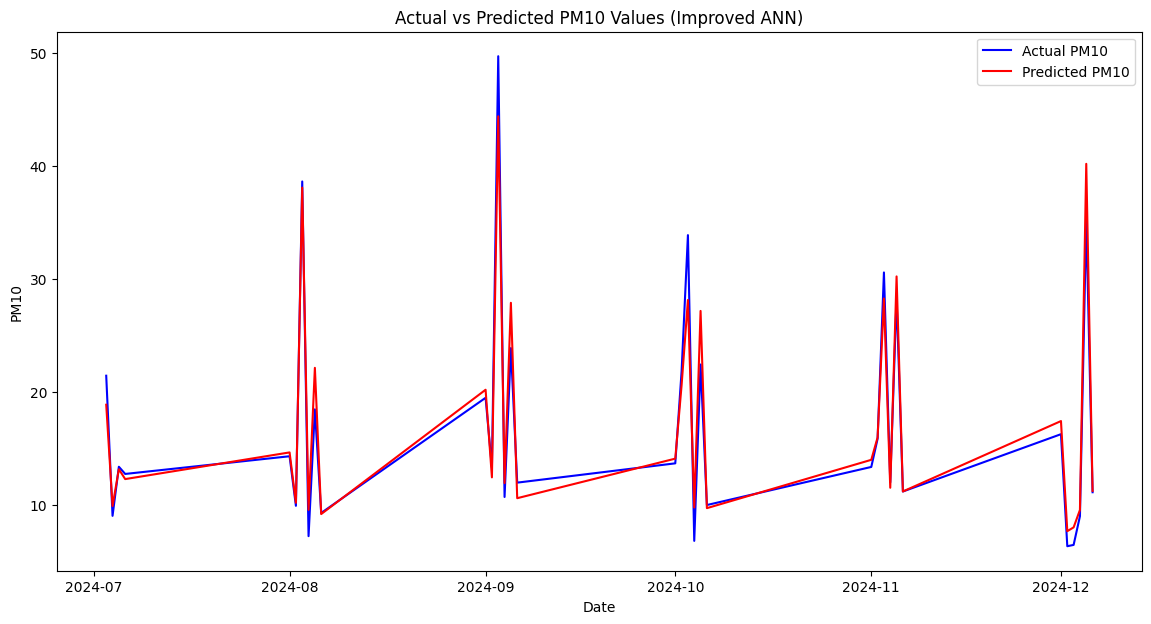

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test_inv, label='Actual PM10', color='blue')
plt.plot(test_data.index, ann2_pred_inv, label='Predicted PM10', color='red')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10 Values (Improved ANN)')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE and MAE
ann2_rmse = np.sqrt(mean_squared_error(y_test_inv, ann2_pred_inv))
ann2_mae = mean_absolute_error(y_test_inv, ann2_pred_inv)
print(f"ANN 2 RMSE: {ann2_rmse}")
print(f"ANN 2 MAE: {ann2_mae}")

ANN 2 RMSE: 2.3078880717414285
ANN 2 MAE: 1.62359201340533


ANN 3

In [ ]:
# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Prepare features and target variable
X_train = train_data[exogenous_vars]
y_train = train_data['PM10']
X_test = test_data[exogenous_vars]
y_test = test_data['PM10']

In [ ]:
# Build the Revised ANN model
an3_model = Sequential()
an3_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
an3_model.add(Dense(64, activation='relu'))
an3_model.add(Dense(32, activation='relu'))
an3_model.add(Dense(1))

# Compile the model
an3_model.compile(optimizer='adam', loss='mean_squared_error')

# Use early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = an3_model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping], verbose=1)

# Make predictions on the test set
y_pred = an3_model.predict(X_test)

# Inverse transform the predictions and actual values
ann3_pred_inv = scaler.inverse_transform(np.concatenate([X_test, y_pred], axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate([X_test, y_test.values.reshape(-1, 1)], axis=1))[:, -1]

Epoch 1/80
4/4 [==============================] - 2s 102ms/step - loss: 0.0189 - val_loss: 0.0089
Epoch 2/80
4/4 [==============================] - 0s 17ms/step - loss: 0.0059 - val_loss: 0.0107
Epoch 3/80
4/4 [==============================] - 0s 55ms/step - loss: 0.0061 - val_loss: 0.0069
Epoch 4/80
4/4 [==============================] - 0s 62ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 5/80
4/4 [==============================] - 0s 75ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 6/80
4/4 [==============================] - 0s 54ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/80
4/4 [==============================] - 0s 43ms/step - loss: 7.6253e-04 - val_loss: 0.0012
Epoch 8/80
4/4 [==============================] - 0s 28ms/step - loss: 8.0765e-04 - val_loss: 2.3860e-04
Epoch 9/80
4/4 [==============================] - 0s 17ms/step - loss: 3.4060e-04 - val_loss: 4.0362e-04
Epoch 10/80
4/4 [==============================] - 0s 38ms/step - loss: 3.7227e-04 - val_loss: 8.9321e-05


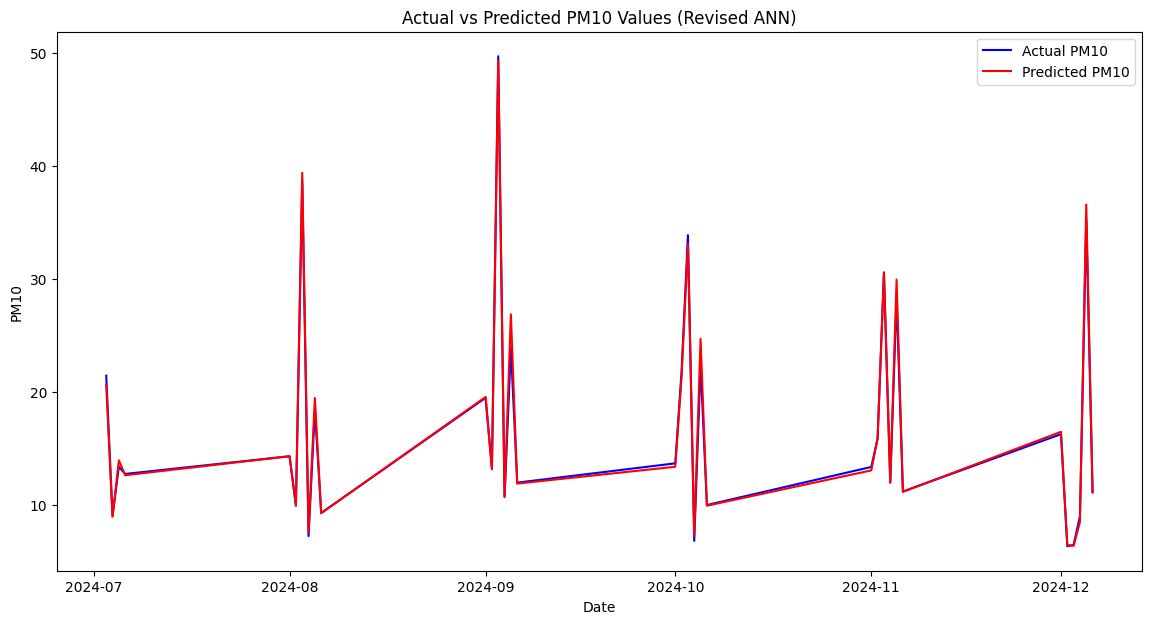

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test_inv, label='Actual PM10', color='blue')
plt.plot(test_data.index, ann3_pred_inv, label='Predicted PM10', color='red')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10 Values (Revised ANN)')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE and MAE
ann3_rmse = np.sqrt(mean_squared_error(y_test_inv, ann3_pred_inv))
ann3_mae = mean_absolute_error(y_test_inv, ann3_pred_inv)
print(f"ANN 3 RMSE: {ann3_rmse}")
print(f"ANN 3 MAE: {ann3_mae}")

ANN 3 RMSE: 0.8178161664116417
ANN 3 MAE: 0.47236064760348206



LSTM



In [ ]:
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [ ]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
lstm_model.add(LSTM(32, return_sequences=False))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Reshape data for LSTM
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

# Train the LSTM model
history = lstm_model.fit(X_train_lstm, y_train, epochs=80, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = lstm_model.predict(X_test_lstm)

# Inverse transform the predictions and actual values
lstm1_pred_inv = scaler.inverse_transform(np.concatenate([X_test, y_pred], axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate([X_test, y_test.values.reshape(-1, 1)], axis=1))[:, -1]

Epoch 1/80
4/4 [==============================] - 5s 324ms/step - loss: 0.0446 - val_loss: 0.0292
Epoch 2/80
4/4 [==============================] - 0s 21ms/step - loss: 0.0191 - val_loss: 0.0118
Epoch 3/80
4/4 [==============================] - 0s 21ms/step - loss: 0.0081 - val_loss: 0.0117
Epoch 4/80
4/4 [==============================] - 0s 21ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 5/80
4/4 [==============================] - 0s 21ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 6/80
4/4 [==============================] - 0s 19ms/step - loss: 0.0063 - val_loss: 0.0085
Epoch 7/80
4/4 [==============================] - 0s 23ms/step - loss: 0.0069 - val_loss: 0.0084
Epoch 8/80
4/4 [==============================] - 0s 22ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 9/80
4/4 [==============================] - 0s 21ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 10/80
4/4 [==============================] - 0s 24ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 11/80
4/4 [===========

In [ ]:
# Calculate RMSE and MAE
lstm1_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm1_pred_inv))
lstm1_mae = mean_absolute_error(y_test_inv, lstm1_pred_inv)
print(f"LSTM 1 RMSE: {lstm1_rmse}")
print(f"LSTM 1 MAE: {lstm1_mae}")

LSTM 1 RMSE: 4.66867044737748
LSTM 1 MAE: 2.986443034604267


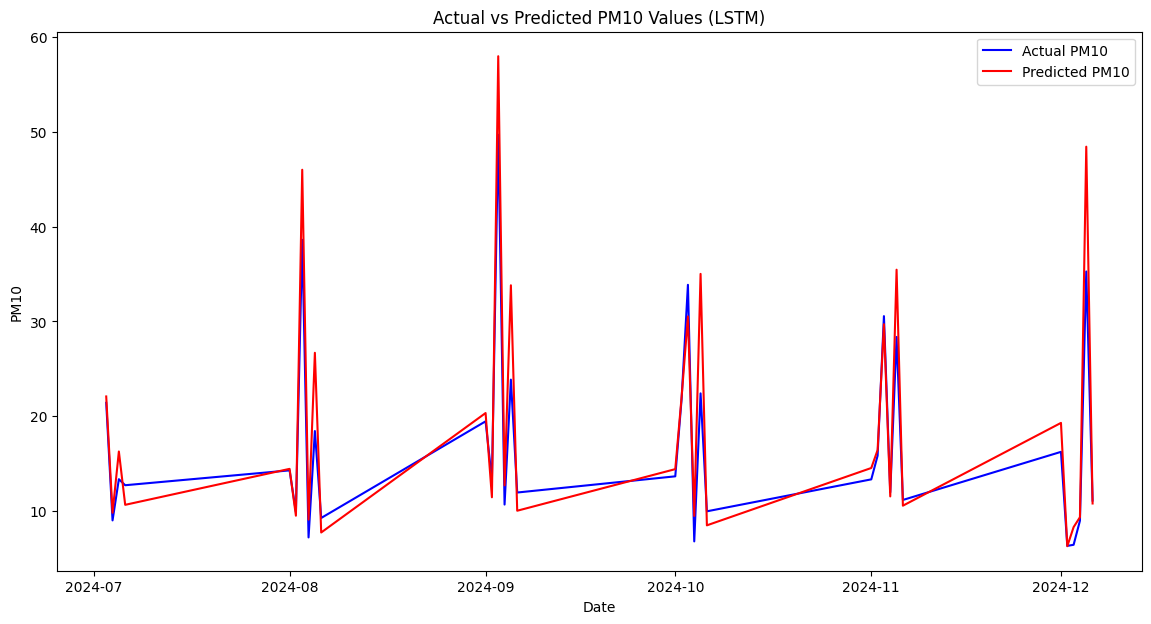

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test_inv, label='Actual PM10', color='blue')
plt.plot(test_data.index, lstm1_pred_inv, label='Predicted PM10', color='red')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10 Values (LSTM)')
plt.legend()
plt.show()



LSTM 2



In [ ]:
# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [ ]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Use early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = lstm_model.fit(X_train_lstm, y_train, epochs=64, batch_size=24, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = lstm_model.predict(X_test_lstm)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(np.concatenate([X_test, y_pred], axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate([X_test, y_test.values.reshape(-1, 1)], axis=1))[:, -1]

Epoch 1/64
5/5 [==============================] - 9s 531ms/step - loss: 0.0384 - val_loss: 0.0163
Epoch 2/64
5/5 [==============================] - 0s 44ms/step - loss: 0.0125 - val_loss: 0.0172
Epoch 3/64
5/5 [==============================] - 0s 38ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 4/64
5/5 [==============================] - 0s 46ms/step - loss: 0.0091 - val_loss: 0.0117
Epoch 5/64
5/5 [==============================] - 0s 25ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 6/64
5/5 [==============================] - 0s 27ms/step - loss: 0.0063 - val_loss: 0.0071
Epoch 7/64
5/5 [==============================] - 0s 33ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 8/64
5/5 [==============================] - 0s 25ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 9/64
5/5 [==============================] - 0s 28ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/64
5/5 [==============================] - 0s 26ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 11/64
5/5 [===========

In [ ]:
# Calculate RMSE and MAE
lstm2_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
lstm2_mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"LSTM 2 RMSE: {lstm2_rmse}")
print(f"LSTM 2 MAE: {lstm2_mae}")

LSTM 2 RMSE: 5.166932623913977
LSTM 2 MAE: 3.4506112681606687


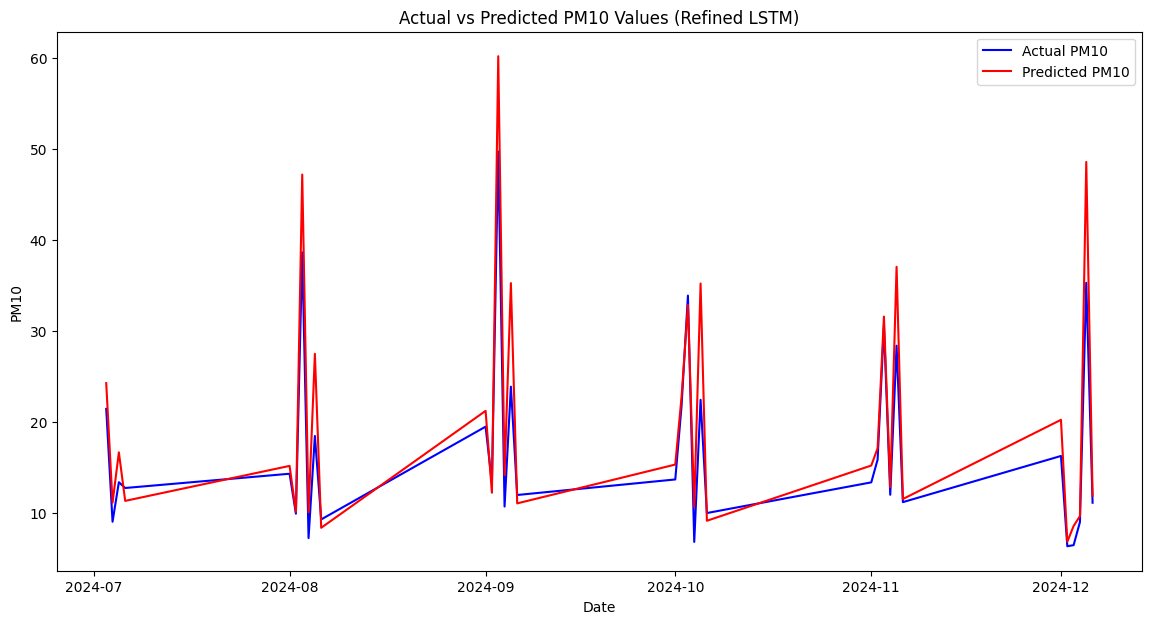

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test_inv, label='Actual PM10', color='blue')
plt.plot(test_data.index, y_pred_inv, label='Predicted PM10', color='red')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10 Values (Refined LSTM)')
plt.legend()
plt.show()

LSTM 3

In [ ]:
# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [ ]:
# Build the simplified LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(84, input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
lstm_model.add(LSTM(42, return_sequences=False))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Use early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = lstm_model.fit(X_train_lstm, y_train, epochs=84, batch_size=20, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = lstm_model.predict(X_test_lstm)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(np.concatenate([X_test, y_pred], axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate([X_test, y_test.values.reshape(-1, 1)], axis=1))[:, -1]

Epoch 1/84
6/6 [==============================] - 5s 281ms/step - loss: 0.0369 - val_loss: 0.0150
Epoch 2/84
6/6 [==============================] - 0s 25ms/step - loss: 0.0097 - val_loss: 0.0148
Epoch 3/84
6/6 [==============================] - 0s 25ms/step - loss: 0.0097 - val_loss: 0.0083
Epoch 4/84
6/6 [==============================] - 0s 24ms/step - loss: 0.0064 - val_loss: 0.0086
Epoch 5/84
6/6 [==============================] - 0s 27ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 6/84
6/6 [==============================] - 0s 31ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 7/84
6/6 [==============================] - 0s 25ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 8/84
6/6 [==============================] - 0s 26ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 9/84
6/6 [==============================] - 0s 28ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 10/84
6/6 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 11/84
6/6 [===========

In [ ]:
# Calculate RMSE and MAE
lstm3_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
lstm3_mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"LSTM 3 RMSE: {lstm3_rmse}")
print(f"LSTM 3 MAE: {lstm3_mae}")

LSTM 3 RMSE: 3.907676436092395
LSTM 3 MAE: 2.6479336665933



GRU



In [ ]:
from tensorflow.keras.layers import GRU

In [ ]:
# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [ ]:
# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(84, input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
gru_model.add(GRU(42, return_sequences=False))
gru_model.add(Dense(1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Use early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the GRU model
history = gru_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred = gru_model.predict(X_test_lstm)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(np.concatenate([X_test, y_pred], axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate([X_test, y_test.values.reshape(-1, 1)], axis=1))[:, -1]

Epoch 1/100
4/4 [==============================] - 6s 451ms/step - loss: 0.0391 - val_loss: 0.0146
Epoch 2/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0099 - val_loss: 0.0166
Epoch 3/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0135 - val_loss: 0.0111
Epoch 4/100
4/4 [==============================] - 0s 41ms/step - loss: 0.0073 - val_loss: 0.0094
Epoch 5/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0074 - val_loss: 0.0106
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 7/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0053 - val_loss: 0.0064
Epoch 8/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0049 - val_loss: 0.0065
Epoch 9/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 10/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 11/100
4/4 [

In [ ]:
# Calculate RMSE and MAE
gru_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
gru_mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"GRU RMSE: {gru_rmse}")
print(f"GRU MAE: {gru_mae}")

GRU RMSE: 3.4482488944423046
GRU MAE: 2.4514081592087447


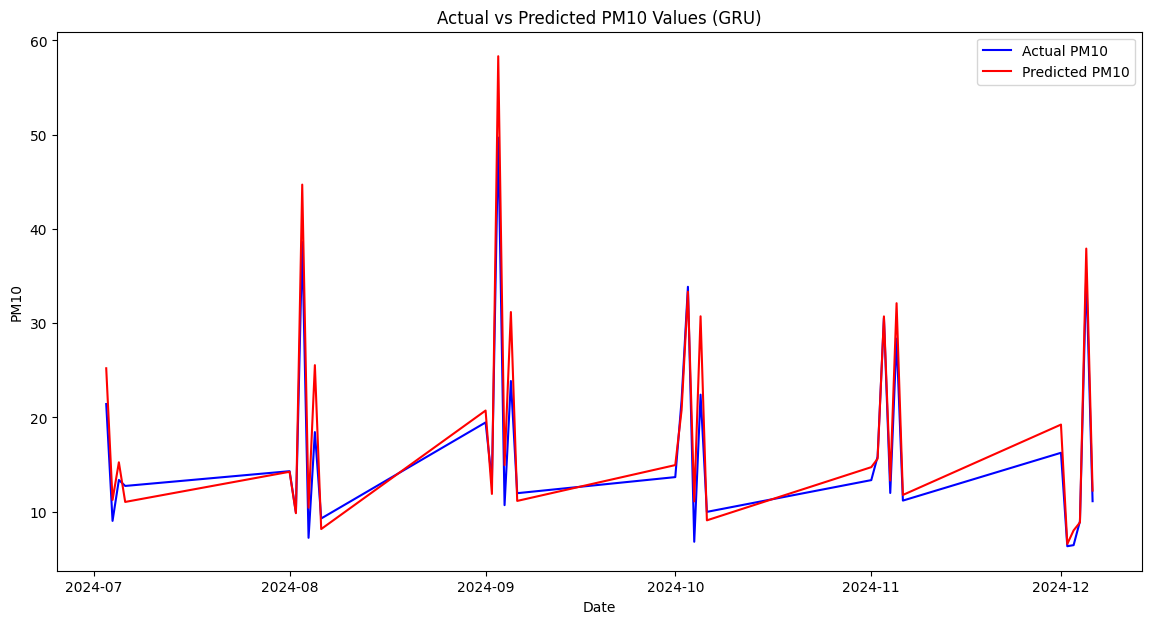

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test_inv, label='Actual PM10', color='blue')
plt.plot(test_data.index, y_pred_inv, label='Predicted PM10', color='red')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10 Values (GRU)')
plt.legend()
plt.show()

Prohpet 1

In [ ]:
from prophet import Prophet

In [ ]:
# Prepare the data for Prophet
prophet_data = data[['PM10']].reset_index()
prophet_data.rename(columns={'Date and Time': 'ds', 'PM10': 'y'}, inplace=True)

# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Split the data into train and test sets
train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data.iloc[:train_size]
test_data = prophet_data.iloc[train_size:]

# Remove timezone information
prophet_data['ds'] = pd.to_datetime(prophet_data['ds']).dt.tz_localize(None)

# Split the data into train and test sets
train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data.iloc[:train_size]
test_data = prophet_data.iloc[train_size:]

# Initialize the Prophet model
p_model = Prophet()

# Fit the model
p_model.fit(train_data)

# Make future dataframe for predictions
future = p_model.make_future_dataframe(periods=len(test_data))

# Make predictions
forecast = p_model.predict(future)

test_data['yhat'] = forecast['yhat'].iloc[-len(test_data):].values
prophet1_rmse = np.sqrt(mean_squared_error(test_data['y'], test_data['yhat']))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd2ci8a7h/p_f_1ae7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd2ci8a7h/fdcp1x0j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13424', 'data', 'file=/tmp/tmpd2ci8a7h/p_f_1ae7.json', 'init=/tmp/tmpd2ci8a7h/fdcp1x0j.json', 'output', 'file=/tmp/tmpd2ci8a7h/prophet_modelajwtxojs/prophet_model-20240624155405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:54:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-182-9e09a2acd72d>:36: Set

In [ ]:
# Calculate RMSE and MAE
print(f"Prophet 1 RMSE: {prophet1_rmse}")
prophet1_mae = mean_absolute_error(test_data['y'], test_data['yhat'])
print(f"Prophet 1 MAE: {prophet1_mae}")

Prophet 1 RMSE: 0.23183342443290253
Prophet 1 MAE: 0.1622423074068242


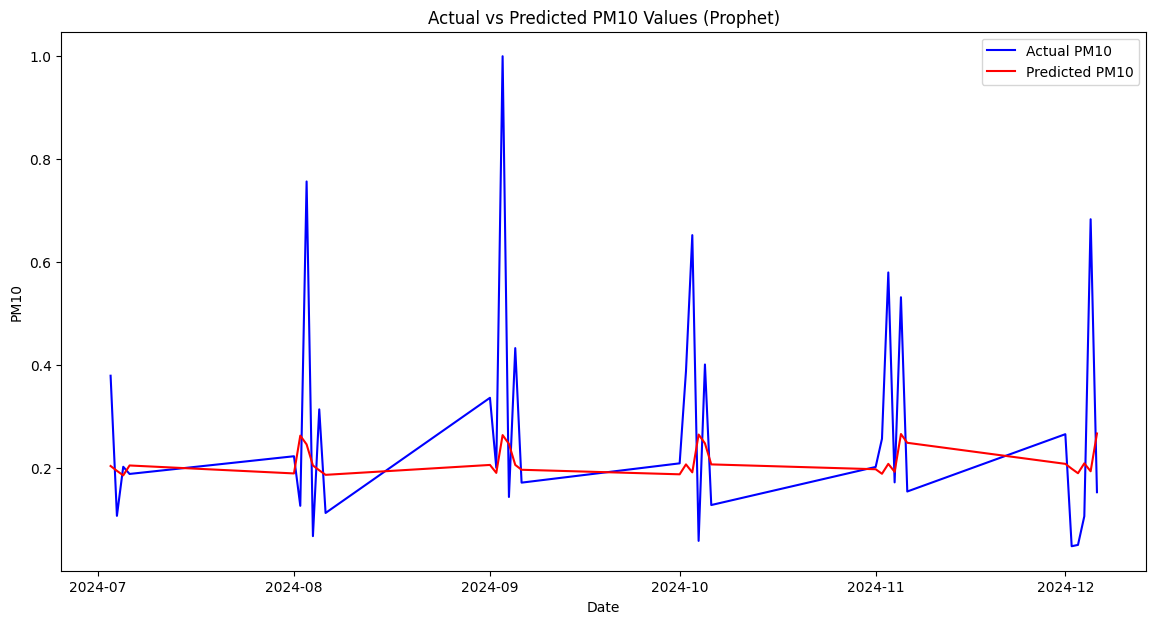

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_data['ds'], test_data['y'], label='Actual PM10', color='blue')
plt.plot(test_data['ds'], test_data['yhat'], label='Predicted PM10', color='red')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10 Values (Prophet)')
plt.legend()
plt.show()

XGBoost

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

In [ ]:
# Specify the exogenous variables
exogenous_vars = [
    'NO2', 'PM2.5', 'PM10_RollingMean_3', 'PM10_RollingMean_1', 'PM10_Pct_Change', 'PM2.5_Pct_Change',
    'PM10_NO2_Product'
]

# Create features and target variable
X = data[exogenous_vars]
y = data['PM10']

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_scaled)

# Calculate RMSE and MAE
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost RMSE: {xgb_rmse}")
print(f"XGBoost MAE: {xgb_mae}")

XGBoost RMSE: 0.06154802342441268
XGBoost MAE: 0.017683323517381087


<Figure size 7000x4000 with 0 Axes>

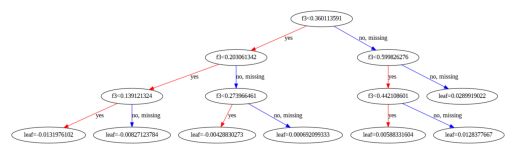

In [ ]:
# Visualize a single decision tree from the XGBoost model
plt.figure(figsize=(70, 40))
xgb.plot_tree(xgb_model, num_trees=0)
plt.show()

In [ ]:
#import os
# Define the directory and filename
#directory = '/content/drive/MyDrive'
#filename = 'xgboost_tree.png'
#filepath = os.path.join(directory, filename)

# Save the plot as an image file
#plt.savefig(filepath, bbox_inches='tight')

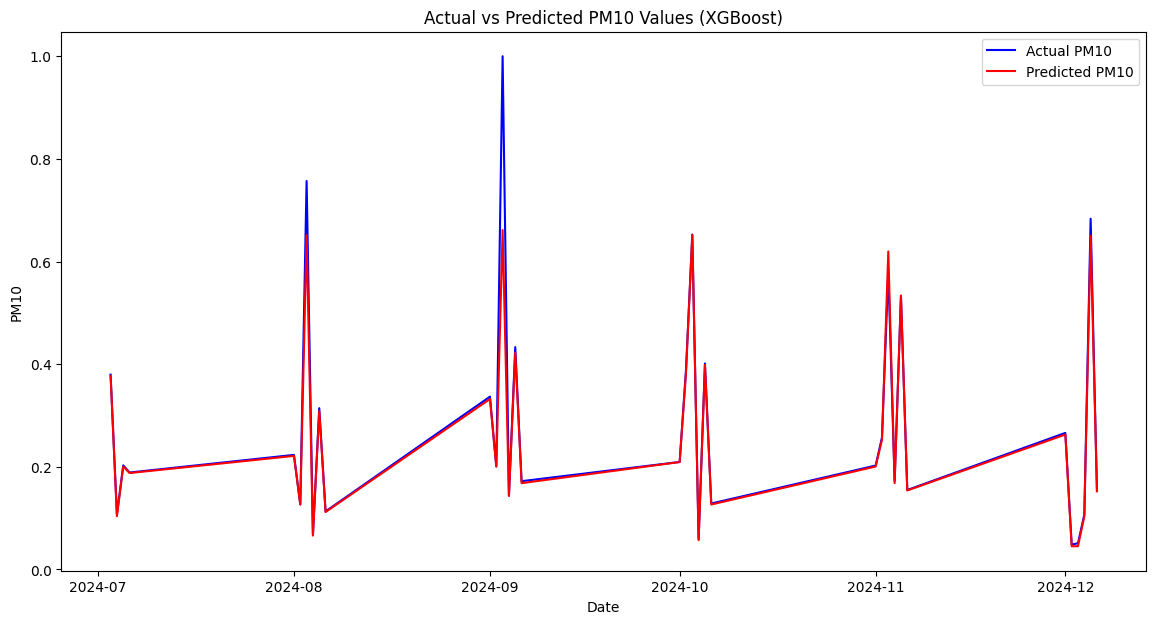

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual PM10', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted PM10', color='red')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10 Values (XGBoost)')
plt.legend()
plt.show()

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=15,
                                 random_state=42,
                                 max_depth=10,
                                 min_samples_split=6,
                                 min_samples_leaf=2 )
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)


# Calculate RMSE and MAE
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest MAE: {rf_mae}")

Random Forest RMSE: 0.07842289736608574
Random Forest MAE: 0.026224265819244343


In [ ]:
single_tree = rf_model.estimators_[0]

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

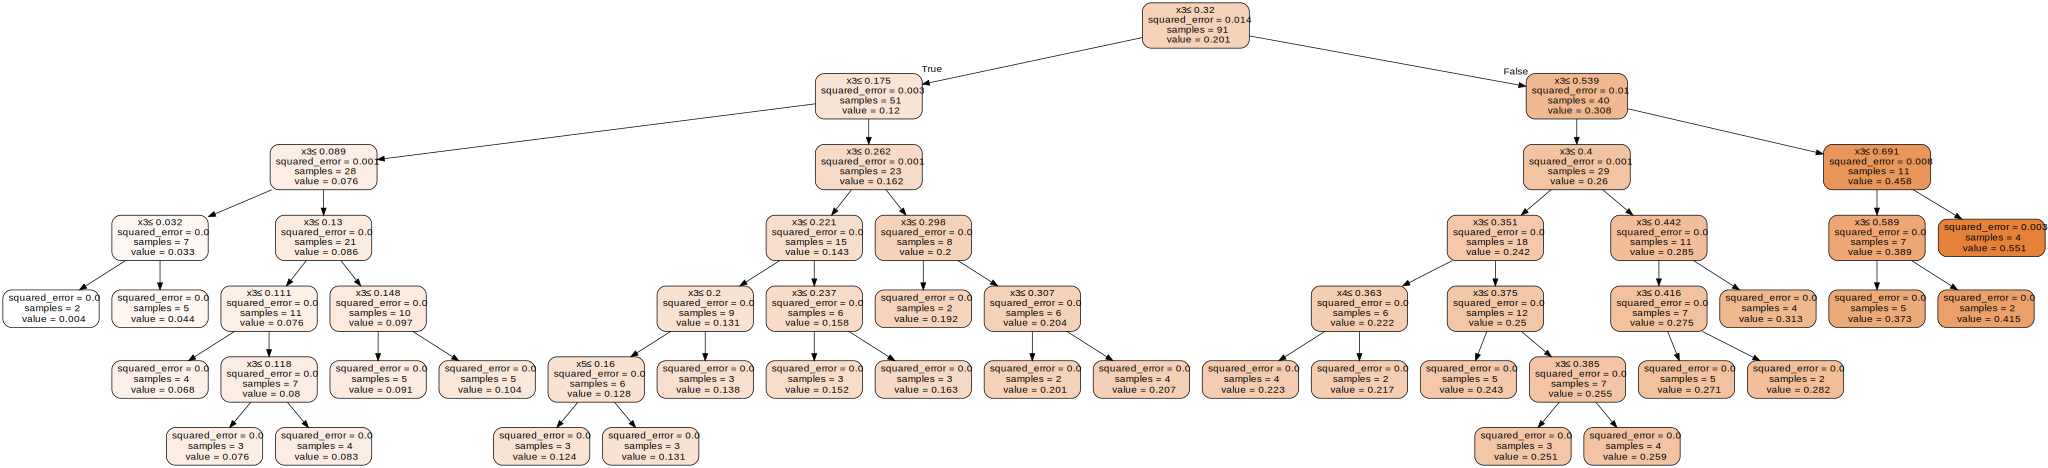

In [ ]:
dot_data = export_graphviz(single_tree,
                           out_file=None,
                           feature_names=X_train_scaled.columns if isinstance(X_train_scaled, pd.DataFrame) else None,
                           filled=True,
                           rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
display(graph)

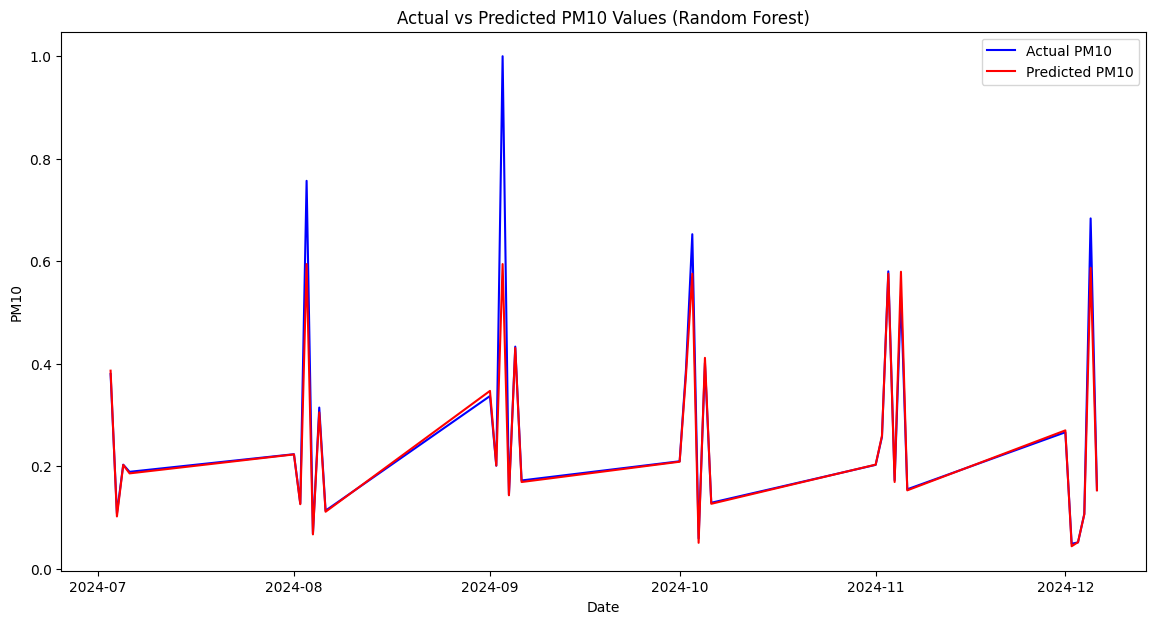

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual PM10', color='blue')
plt.plot(y_test.index, y_pred_rf, label='Predicted PM10', color='red')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10 Values (Random Forest)')
plt.legend()
plt.show()

Ensemble model


In [ ]:
# RMSE of all Machine Learning models and ARIMAX
print(f"ARIMAX RMSE: {arimax_rmse}")
print(f"ANN 1 RMSE: {ann1_rmse}")
print(f"ANN 2 RMSE: {ann2_rmse}")
print(f"ANN 3 RMSE: {ann3_rmse}")
print(f"LSTM 1 RMSE: {lstm1_rmse}")
print(f"LSTM 2 RMSE: {lstm2_rmse}")
print(f"LSTM 3 RMSE: {lstm3_rmse}")
print(f"GRU RMSE: {gru_rmse}")
print(f"Prophet 1 RMSE: {prophet1_rmse}")
print(f"XGBoost RMSE: {xgb_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")

ARIMAX RMSE: 9.248503511698828e-09
ANN 1 RMSE: 1.206312281556195
ANN 2 RMSE: 2.3078880717414285
ANN 3 RMSE: 0.8178161664116417
LSTM 1 RMSE: 4.66867044737748
LSTM 2 RMSE: 5.166932623913977
LSTM 3 RMSE: 3.907676436092395
GRU RMSE: 3.4482488944423046
Prophet 1 RMSE: 0.23183342443290253
XGBoost RMSE: 0.06154802342441268
Random Forest RMSE: 0.07842289736608574


In [ ]:
# MAE of all Machine Learning models and ARIMAX
print(f"ARIMAX MAE: {arimax_mae}")
print(f"ANN 1 MAE: {ann1_mae}")
print(f"ANN 2 MAE: {ann2_mae}")
print(f"ANN 3 MAE: {ann3_mae}")
print(f"LSTM 1 MAE: {lstm1_mae}")
print(f"LSTM 2 MAE: {lstm2_mae}")
print(f"LSTM 3 MAE: {lstm3_mae}")
print(f"GRU MAE: {gru_mae}")
print(f"Prophet 1 MAE: {prophet1_mae}")
print(f"XGBoost MAE: {xgb_mae}")
print(f"Random Forest MAE: {rf_mae}")

ARIMAX MAE: 9.195363111470054e-09
ANN 1 MAE: 0.8436929956848929
ANN 2 MAE: 1.62359201340533
ANN 3 MAE: 0.47236064760348206
LSTM 1 MAE: 2.986443034604267
LSTM 2 MAE: 3.4506112681606687
LSTM 3 MAE: 2.6479336665933
GRU MAE: 2.4514081592087447
Prophet 1 MAE: 0.1622423074068242
XGBoost MAE: 0.017683323517381087
Random Forest MAE: 0.026224265819244343


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize


rmse_data = {
    "Model": ["ARIMAX", "ANN 1", "ANN 2", "ANN 3", "LSTM 1", "LSTM 2", "LSTM 3", "GRU", "Prophet 1", "XGBoost", "Random Forest"],
    "RMSE": [arimax_rmse, ann1_rmse, ann2_rmse, ann3_rmse, lstm1_rmse, lstm2_rmse, lstm3_rmse, gru_rmse, prophet1_rmse, xgb_rmse, rf_rmse]
}

# Create the DataFrame
rmse_df = pd.DataFrame(rmse_data)

# Sort models by RMSE
rmse_df = rmse_df.sort_values(by='RMSE')

# Select top N models
top_n = 5
selected_models = rmse_df.head(top_n)

# Ensure that selected_models only contains models present in predictions dictionary
available_models = ["ARIMAX", "ANN 3", "Prophet 1", "XGBoost", "Random Forest"]
selected_models = selected_models[selected_models['Model'].isin(available_models)]

# Display the selected models
print("Selected models:")
print(selected_models[['Model', 'RMSE']])

# Dictionary with predictions from each model
predictions = {
    'ARIMAX': arimax_pred_mean,
    'ANN 3': ann3_pred_inv,
    'Prophet 1': forecast['yhat'].iloc[-len(test_data):].values,
    'XGBoost': y_pred,
    'Random Forest': y_pred_rf
}

# Actual values
actual_values = y_test

# Ensure all predictions are in a numpy array format and have the same shape
for model in predictions:
    predictions[model] = np.array(predictions[model])

# Collect predictions in a single matrix
X = np.column_stack([predictions[model] for model in selected_models['Model']])

# Objective function for optimization
def objective(weights):
    ensemble_prediction = np.dot(X, weights)
    return np.sqrt(mean_squared_error(actual_values, ensemble_prediction))

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds for weights: between 0 and 1
bounds = [(0, 1) for _ in range(X.shape[1])]

# Initial guess for weights
initial_weights = np.ones(X.shape[1]) / X.shape[1]

# Optimize the weights
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimal weights
optimal_weights = result.x
print(f"Optimal weights: {optimal_weights}")

# Calculate the weighted ensemble prediction using optimal weights
ensemble_prediction = np.dot(X, optimal_weights)

# Scale the ensemble predictions using the same scaler as actual values
scaler = MinMaxScaler()
scaler.fit(actual_values.values.reshape(-1, 1))

# Scale the ensemble prediction
scaled_ensemble_prediction = scaler.transform(ensemble_prediction.reshape(-1, 1)).flatten()

# Calculate the RMSE of the scaled ensemble prediction
scaled_ensemble_rmse = np.sqrt(mean_squared_error(actual_values, scaled_ensemble_prediction))
print(f"RMSE ensemble model: {scaled_ensemble_rmse}")

Selected models:
            Model          RMSE
0          ARIMAX  9.248504e-09
9         XGBoost  6.154802e-02
10  Random Forest  7.842290e-02
8       Prophet 1  2.318334e-01
3           ANN 3  8.178162e-01
Optimal weights: [1.64130739e-03 9.98358693e-01 7.82170552e-16 0.00000000e+00
 0.00000000e+00]
RMSE ensemble model: 0.054693889489670536


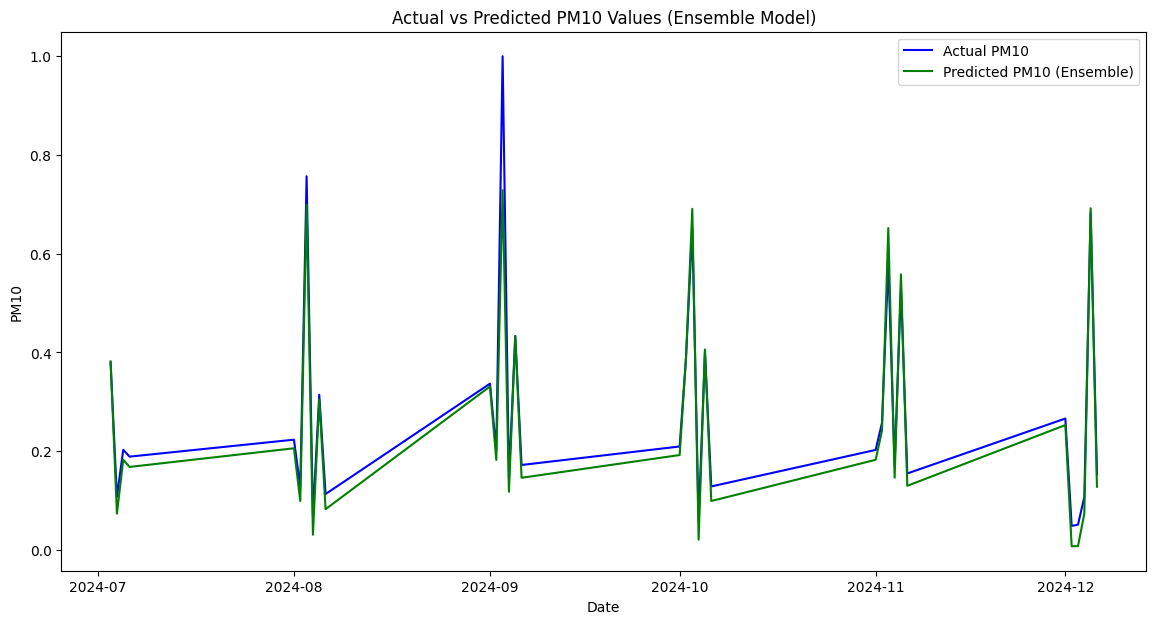

In [ ]:
# Plot the actual vs predicted values for the ensemble model
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual PM10', color='blue')
plt.plot(y_test.index, scaled_ensemble_prediction, label='Predicted PM10 (Ensemble)', color='green')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10 Values (Ensemble Model)')
plt.legend()
plt.show()

**Saving the ensemble model with weights**

In [ ]:
#import pickle
#import joblib

In [ ]:
# Save the individual models to Google Drive
#joblib.dump(arimax_model, '/content/drive/My Drive/arimax_model.pkl')
#an3_model.save(model,'/content/drive/My Drive/ann3_model.pkl')
#joblib.dump(xgb_model, '/content/drive/My Drive/xgb_model.pkl')
#joblib.dump(rf_model, '/content/drive/My Drive/rf_model.pkl')
#with open('/content/drive/My Drive/prophet_model.pkl', 'wb') as f:
 #   pickle.dump(p_model, f)

# Save the optimal weights to Google Drive
#with open('/content/drive/My Drive/ensemble_weights.pkl', 'wb') as f:
 #   pickle.dump(optimal_weights, f)